-------------
# DICOM Dataset EDA

We will discuss some of the methods that could be applied in dataset analysis, when you are dealing with large multitude of 3D volumes. A lot of the same principles could be applied here as were used with individual volume EDA.

In this case we will look at a collection of images and try to figure out what we are looking at. We will look at some of the techniques that might help us collect relevant meta information.

In [30]:
import pydicom
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy.ma as ma
import numpy as np
import os

Let us load all series metadata, but not pixels

In [31]:
path = r"data"
series = np.array([[(os.path.join(dp, f), pydicom.dcmread(os.path.join(dp, f), stop_before_pixels = True)) for f in files]
                   for dp,_,files in os.walk(path) if len(files) != 0])



Let's print a few, see what we've got:

In [32]:
series[0][0][1]

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'OTHER']
(0008, 0016) SOP Class UID                       UI: MR Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.14519.5.2.1.4429.7055.356441949447181979354734381747
(0008, 0020) Study Date                          DA: '19961210'
(0008, 0021) Series Date                         DA: '19961210'
(0008, 0023) Content Date                        DA: '19961210'
(0008, 0030) Study Time                          TM: '092850'
(0008, 0031) Series Time                         TM: '095144'
(0008, 0033) Content Time                        TM: '095144'
(0008, 0050) Accession Number                    SH: '2436893741185310'
(0008, 0060) Modality                            CS: 'MR'
(0008, 0070) Manufacturer                        LO: 'Imaging Biometrics LLC'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 1030) Study

*Looks like we have MR data*  
*Looks like we can rely on patient IDs*

How many total files

In [33]:
instances = [f for l in series for f in l]
len(instances)

1794

How many patients?

In [34]:
patient_ids = np.unique([inst[1].PatientID for inst in instances])
len(patient_ids)

4

*Great - no errors hence all instances have the PatientID tag, and looks like we can rely on it*

How many total series (i.e. 3D volumes)?

In [35]:
len(series)

76

What is the relationship between patients, studies and series?

In [36]:
# How many studies?

studies = {}

for s in series:
    studies.setdefault(s[0][1].StudyInstanceUID, []).append(s)   

In [37]:
len(studies)

8

Let's see how many studies per patient

In [38]:
[len([st for st in studies.values() if st[0][0][1].PatientID == p]) for p in patient_ids]

[2, 2, 2, 2]

*Nice, all even. Let's look at directory on the file system.*  
*Looks like 2 points in time per patient*

In [39]:
# Let's see how many series per study

series_per_study = [(len(sr), sr[0][0][1].PatientID) for sr in studies.values()]
series_per_study

[(10, 'PGBM-006'),
 (6, 'PGBM-006'),
 (10, 'PGBM-001'),
 (10, 'PGBM-001'),
 (10, 'PGBM-003'),
 (10, 'PGBM-003'),
 (10, 'PGBM-008'),
 (10, 'PGBM-008')]

Let's take a quick glimpse at that outlier on the file system. 

- seems like it's missing some sequences

Finally, how many images per series:

In [40]:
img_per_series = [len(s) for s in series]
print(img_per_series)

[24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24]


*Nice, no outliers*

Let's look at spacing and in-plane resolution:

In [41]:
res = {}
spc = {}
thck = {}

for sr in series:
    dcm = sr[0][1]
    key = str(dcm.PixelSpacing)
    spc.setdefault(key, [])
    spc[key].append((dcm.PatientID, dcm.StudyDescription, dcm.StudyDate, dcm.SeriesDescription))
    
    key = str((dcm.Rows, dcm.Columns))
    res.setdefault(key, [])
    res[key].append((dcm.PatientID, dcm.StudyDescription, dcm.StudyDate, dcm.SeriesDescription))
    
    key = str(dcm.SliceThickness)
    thck.setdefault(key, [])
    thck[key].append((dcm.PatientID, dcm.StudyDescription, dcm.StudyDate, dcm.SeriesDescription))
    


Let's look at slice thickness

In [42]:
thck.keys()

dict_keys(['5', '5.000000'])

*Great, all consistent*

Let's look at pixel spacing

In [43]:
spc.keys()

dict_keys(['[0.4297, 0.4297]', '[0.429700, 0.429700]', '[0.42970000000000, 0.42970000000000]', '[0.68750000000000, 0.68750000000000]', '[0.6875, 0.6875]', '[0.687500, 0.687500]'])

*Not very consistent, let's try to see what is going on*

In [44]:
spc

{'[0.4297, 0.4297]': [('PGBM-006',
   'MR RCBV SEQUENCE',
   '19961210',
   'T1pre_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'T1post'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'T2_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'FLAIR_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'T1pre_reg'),
  ('PGBM-003', 'MR RCBV SEQUENCE', '19951017', 'T1pre_reg'),
  ('PGBM-003', 'MR RCBV SEQUENCE', '19951017', 'FLAIR_reg'),
  ('PGBM-003', 'MR RCBV SEQUENCE', '19951017', 'T2_reg'),
  ('PGBM-003', 'MR RCBV SEQUENCE', '19951017', 'T1post'),
  ('PGBM-008', 'MR RCBV SEQUENCE FH', '19920331', 'T1post'),
  ('PGBM-008', 'MR RCBV SEQUENCE FH', '19920331', 'FLAIR_reg'),
  ('PGBM-008', 'MR RCBV SEQUENCE FH', '19920331', 'T2_reg')],
 '[0.429700, 0.429700]': [('PGBM-006',
   'MR RCBV SEQUENCE',
   '19961210',
   'Mask_Tumor'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'Mask_Tumor'),
  ('PGBM-003', 'MR RCBV SEQUENCE', '19951017', 'Mask_Tumor'),
  ('PGBM-008', 'MR RCBV SEQU

*So looks like there is a slight discrepancy among T1/T2 series. Note to self - make sure to resample if I'm using them.  
Also, seems that some sequences have tighter pixels than others. If I'm using those, need to make sure resampling is meaningful*

Let's look at in-plane resolution

In [45]:
res.keys()

dict_keys(['(512, 512)', '(320, 260)', '(320, 280)'])

*Not a lot of variety, but clearly some seq types are high-res, need to see what's up*

In [46]:
res

{'(512, 512)': [('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'T1pre_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'Mask_Tumor'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'nRCBV_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'nCBF_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'T1post'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'ADC_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'T2_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'sRCBV_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'FLAIR_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19961210', 'dT1'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'ADC_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'nRCBV_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'nCBF_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'T1pre_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'sRCBV_reg'),
  ('PGBM-006', 'MR RCBV SEQUENCE', '19970211', 'Mask_Tumor'),
  ('PGBM-003', 'MR RCBV SE

Now let's visualize some of those images and see if the series align with each other

In [47]:
# Let's try to see how images from same series stack w each other. We might want to use multiple
# input channels for our problem

# Remember, though, that we don't have the pixel data? Let's load it properly:

seq1 = r"PGBM-003/10-17-1995-MR RCBV SEQUENCE-57198/34911-T1prereg-46949"
t1_slices = [pydicom.dcmread(os.path.join(path, seq1, f)) for f in os.listdir(os.path.join(path, seq1))]
t1_slices.sort(key = lambda inst: int(inst.ImagePositionPatient[2]))

seq2 = r"PGBM-003/10-17-1995-MR RCBV SEQUENCE-57198/36471-FLAIRreg-02052"
flair_slices = [pydicom.dcmread(os.path.join(path, seq2, f)) for f in os.listdir(os.path.join(path, seq2))]
flair_slices.sort(key = lambda inst: int(inst.ImagePositionPatient[2]))

In [48]:
# t1_slices[0]

In [49]:
# flair_slices[0]

In [50]:
t1 = np.stack([s.pixel_array for s in t1_slices])
flair = np.stack([s.pixel_array for s in flair_slices])

In [51]:
[ipp.ImagePositionPatient for ipp in t1_slices]

[[-109.536, -158.482, -59.1396],
 [-109.536, -157.977, -52.6593],
 [-109.536, -157.472, -46.179],
 [-109.536, -156.966, -39.6986],
 [-109.536, -156.461, -33.2183],
 [-109.536, -155.956, -26.7379],
 [-109.536, -155.451, -20.2576],
 [-109.536, -154.946, -13.7772],
 [-109.536, -154.441, -7.2969],
 [-109.536, -153.936, -0.816556],
 [-109.536, -153.431, 5.66379],
 [-109.536, -152.926, 12.1441],
 [-109.536, -152.421, 18.6245],
 [-109.536, -151.916, 25.1048],
 [-109.536, -151.41, 31.5852],
 [-109.536, -150.905, 38.0655],
 [-109.536, -150.4, 44.5459],
 [-109.536, -149.895, 51.0262],
 [-109.536, -149.39, 57.5065],
 [-109.536, -148.885, 63.9869],
 [-109.536, -148.38, 70.4672],
 [-109.536, -147.875, 76.9476],
 [-109.536, -147.37, 83.4279],
 [-109.536, -146.865, 89.9083]]

In [52]:
[ipp.ImagePositionPatient for ipp in flair_slices]

[[-109.536, -158.482, -59.1396],
 [-109.536, -157.977, -52.6593],
 [-109.536, -157.472, -46.179],
 [-109.536, -156.966, -39.6986],
 [-109.536, -156.461, -33.2183],
 [-109.536, -155.956, -26.7379],
 [-109.536, -155.451, -20.2576],
 [-109.536, -154.946, -13.7772],
 [-109.536, -154.441, -7.2969],
 [-109.536, -153.936, -0.816556],
 [-109.536, -153.431, 5.66379],
 [-109.536, -152.926, 12.1441],
 [-109.536, -152.421, 18.6245],
 [-109.536, -151.916, 25.1048],
 [-109.536, -151.41, 31.5852],
 [-109.536, -150.905, 38.0655],
 [-109.536, -150.4, 44.5459],
 [-109.536, -149.895, 51.0262],
 [-109.536, -149.39, 57.5065],
 [-109.536, -148.885, 63.9869],
 [-109.536, -148.38, 70.4672],
 [-109.536, -147.875, 76.9476],
 [-109.536, -147.37, 83.4279],
 [-109.536, -146.865, 89.9083]]

In [53]:
np.array([ipp.ImageOrientationPatient for ipp in t1_slices]) - np.array([ipp.ImageOrientationPatient for ipp in flair_slices])

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [54]:
t1.shape

(24, 512, 512)

In [55]:
flair.shape

(24, 512, 512)

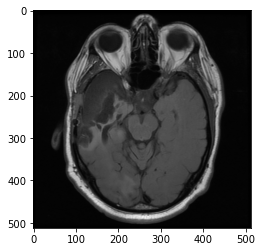

In [56]:
plt.imshow((flair+1.0*t1)[9,:,:], cmap="gray")

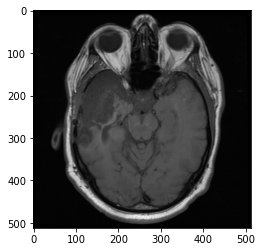

In [57]:
plt.imshow((0.0*flair+t1)[9,:,:], cmap="gray")

At this point we could visualize a few more series, and probably run some code to ensure IPP and IOP alignment across all of the dataset. We could maybe load this data in Slicer to get a feel of what we are dealing with, and then start looking at the ground truth and photometrics. 

However, by going through these simple steps, we already learned the following about our dataset:

* We are dealing with MR images
* We have data from 4 patients
* Each patient has 2 studies representing 2 time points
* Each study has between 8 and 10 series, 76 series altogether
* In total we have 1794 slices
* We have varying pixel spacing, even within same sequence types
* We have consistent slice thickness (5mm)
* We have low-res slices (older ones) and higher-res slices (newer ones)
* Our volumes seem to all be registered together and thus it is safe to just align them. I.e. they could be passed as multi-channel data into our ML algorithms

That is a lot! 